Sweden have a long tradition of keeping statistics of different KPI:s by municipality. Let's see what KPI:s correlate with different voting patterns. And while we're at it, demonstrate some Pandas method chaining – and do a Bayesian analysis of the Pearson product-moment correlation coefficient often denoted as Persons `r`.

Note that the conclusions might mainly be of intrest of Swedes, and there will probably slip in some Swedish. Quick wordlist: `kommun = municipality, brott = crime, gravid = pregnant`.

**TLDR;** Sweden Democrats (SD) shows high correlatons with mothers smoking while pregnant, unemployment and motorcycles. Also the table is a the bottom if you're not interested in code.

And as usual, the Jupyter Notebook (former Ipython notebook) is here in a repo together with the data.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
rcParams['font.sans-serif'] = ['Courier']

Starting with the data from the Swedish election 2014, we can read it directly from an url with the very nice Pandas method `read_html`.

Encapsulating the DataFrame `votes` with parentheseses makes method chaining possible. Every method in fact returns a DataFrame which makes every preprocessing step just another step in the chain.

### Percent votes in Swedish election 2014

In [2]:
votes = (pd.read_html('http://www.val.se/val/val2014/slutresultat/K/rike/index.html')[1]
           .rename(columns={u'Område': 'Kommun'})
           [['Kommun', 'SD', 'M', 'C', 'FP', 'KD', 'S', 'V', 'MP', 'FI', u'ÖVR', 'BLANK']]
           .set_index('Kommun')
           .apply(lambda x: x.str.replace(",", ".")
                             .str.replace("%", "").astype(float))
)
partier = votes.columns
votes.head(3)

,SD,M,C,FP,KD,S,V,MP,FI,ÖVR,BLANK
Kommun,,,,,,,,,,,
Ale,10.64,21.08,4.95,3.28,3.50,33.59,6.25,5.70,0.18,10.83,1.39
Alingsås,7.48,21.58,6.17,10.30,6.44,29.19,6.85,10.81,0.30,0.89,1.21
Alvesta,14.44,19.70,14.89,1.74,3.12,28.77,4.08,3.49,0.20,9.56,1.98


Now let's read some migration patterns straight of the web. I.e. what municipalitys that had a positive net growth in terms of people living there.

### Net inhabitant growth

In [3]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17248'
col = u'Befolkningsökning, 2012-2015, procent, treårsbasis'
befolkningsokning = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u",", u".").astype(float)})
      .set_index('Kommun')
)
befolkningsokning.head(3)

,"Befolkningsökning, 2012-2015, procent, treårsbasis"
Kommun,
Ale,3.7
Alingsås,3.3
Alvesta,2.9


### Rating of how good a municipality is for companies

In [4]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17257'
col = u'Företagsklimat, ranking 1-290, 2015, ordningstal'
foretagsklimat = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].astype(int)})
      .set_index('Kommun')
)
foretagsklimat.head(3)

,"Företagsklimat, ranking 1-290, 2015, ordningstal"
Kommun,
Ale,43
Alingsås,185
Alvesta,221


### Percent people with a higher education

In [5]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17251'
col = u'Andel högskoleutbildade, 2015, procent'
hogskoleutbildning = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u",", u".").astype(float)})
      .set_index('Kommun')
)
hogskoleutbildning.head(3)

,"Andel högskoleutbildade, 2015, procent"
Kommun,
Ale,18.9
Alingsås,24.3
Alvesta,15.0


### Percent early retirees


In [6]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17256'
col = u'Andel förtidspensionärer, 2015, procent'
fortidspensionarer = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u",", u".").astype(float)})
      .set_index('Kommun')
)
fortidspensionarer.head(3)

,"Andel förtidspensionärer, 2015, procent"
Kommun,
Ale,5.5
Alingsås,6.5
Alvesta,6.0


### Median income

In [7]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17249'
col = u'Medianinkomst, 2014, kronor'
medianinkomst = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u"\xa0", u"").astype(int)})
      .set_index('Kommun')
)
medianinkomst.head(3)

,"Medianinkomst, 2014, kronor"
Kommun,
Ale,273684
Alingsås,259211
Alvesta,241077


### Unemployment rate

In [8]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17255'
col = u'Öppen arbetslöshet (Arbetsförmedlingen), 2015, procent'
arbetsloshet = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u",", u".").astype(float)})
      .set_index('Kommun')
)
arbetsloshet.head(3)

,"Öppen arbetslöshet (Arbetsförmedlingen), 2015, procent"
Kommun,
Ale,4.9
Alingsås,5.5
Alvesta,9.3


### Number of crimes per 100k inhabitants

In [9]:
brott = (pd.read_csv("brott_per_1000.txt", sep=";", encoding="latin-1")
        .rename(columns={"Region": "Kommun", "/100 000 inv": "Brott per 100k inv"})
        .groupby("Kommun")
        .sum()
        .reset_index()
        [['Kommun', 'Brott per 100k inv']]
        .assign(Kommun= lambda x: x['Kommun'].str.replace(" kommun", ""))
        .set_index('Kommun'))
brott.head(3)

,Brott per 100k inv
Kommun,
Ale,8231
Alingsås,10511
Alvesta,8300


### Violent crimes

In [10]:
valdsbrott = (pd.read_csv("vbrott_per_1000.txt", sep=";", encoding="latin-1")
        .rename(columns={"Region": "Kommun", "/100 000 inv": u"Våldsbrott per 100k inv"})
        .groupby("Kommun")
        .sum()
        .reset_index()
        [['Kommun', u'Våldsbrott per 100k inv']]
        .assign(Kommun= lambda x: x['Kommun'].str.replace(" kommun", ""))
        .set_index('Kommun'))
valdsbrott.head(3)

,Våldsbrott per 100k inv
Kommun,
Ale,823
Alingsås,870
Alvesta,967


### Drug crimes

In [11]:
knarkbrott = (pd.read_csv("knarkbrott_per_1000.txt", sep=";", encoding="latin-1")
        .rename(columns={"Region": "Kommun", "/100 000 inv": u"Narkotikabrott per 100k inv"})
        .groupby("Kommun")
        .sum()
        .reset_index()
        [['Kommun', u'Narkotikabrott per 100k inv']]
        .assign(Kommun= lambda x: x['Kommun'].str.replace(" kommun", ""))
        .set_index('Kommun'))
knarkbrott.head(3)

,Narkotikabrott per 100k inv
Kommun,
Ale,402
Alingsås,1487
Alvesta,327


### Mean age

In [12]:
url = 'http://www.ekonomifakta.se/Fakta/Regional-statistik/Din-kommun-i-siffror/Nyckeltal-for-regioner/?var=17247'
col = u'Medelålder, 2015, år'
medianalder = (
    pd.read_html(url, thousands=' ')[0]
      .assign(**{col: lambda x: x[col].str.replace(u",", u".").astype(float)})
      .set_index('Kommun')
)
medianalder.head(3)

,"Medelålder, 2015, år"
Kommun,
Ale,39.9
Alingsås,42.0
Alvesta,42.1


### Percent born in another country than Sweden

In [13]:
utrikesfodda = (pd.read_excel("BE0101-Utrikes-fodda-kom-fland.xlsx", header=5)
        .dropna(subset=[u'Kommun'])
        .assign(procent= lambda x: x[u'I procent'].astype(float))
        .rename(columns={'procent': u'Procent utrikesfödda'})
        [['Kommun', u'Procent utrikesfödda']]
        .set_index('Kommun')
)
utrikesfodda.head(3)

,Procent utrikesfödda
Kommun,
Botkyrka,40.1
Danderyd,15.3
Ekerö,11.0


### Percent mothers smoking while pregnant

In [14]:
rokande_grav = (
    pd.read_excel("Lev03.xlsx", header=3)
      .reset_index()
      .rename(columns={'index': 'Kommun', '2014': u'Rökande gravida, procent'})
      .assign(Kommun=lambda x: x['Kommun'].str.split())
      .assign(Kommun=lambda x: x['Kommun'].str[1:])
      .assign(Kommun=lambda x: x['Kommun'].str.join(" "))
      .dropna()
      .set_index('Kommun')
      .replace("..", 0)
      .assign(**{u'Rökande gravida, procent': lambda x: x[u'Rökande gravida, procent'].astype(float)})
)
rokande_grav.head(3)

,"Rökande gravida, procent"
Kommun,
Upplands Väsby,3.6
Vallentuna,2.3
Österåker,2.9


### Rapes per 10k inhabitants

In [15]:
valdtakter = (
    pd.read_excel("Sex03.xlsx", header=3)
      .reset_index()
      .rename(columns={'index': 'Kommun', '2015': u'Våldtäkter per 10k inv'})
      .assign(Kommun=lambda x: x['Kommun'].str.split())
      .assign(Kommun=lambda x: x['Kommun'].str[1:])
      .assign(Kommun=lambda x: x['Kommun'].str.join(" "))
      .dropna()
      .set_index('Kommun')
      .assign(**{u'Våldtäkter per 10k inv': lambda x: x[u'Våldtäkter per 10k inv'].astype(float)})
)
valdtakter.head(3)

,Våldtäkter per 10k inv
Kommun,
Upplands Väsby,5.0
Vallentuna,1.9
Österåker,2.2


### Asylum seekers per 1k inhabitants

In [16]:
asylsokande = (pd.read_excel("asylsdochm.xlsx", header=1)
        .dropna(subset=[u'Kommun'])
        .rename(columns={u'Antal asylsökande per': u'Antal asylsökande per 1000 invånare'})
        [['Kommun', u'Antal asylsökande per 1000 invånare']]
        .set_index('Kommun')
        .assign(**{u'Antal asylsökande per 1000 invånare': lambda x: x[u'Antal asylsökande per 1000 invånare'].astype(float)})

)
asylsokande.head(3)

,Antal asylsökande per 1000 invånare
Kommun,
Ljusnarsberg,138.26
Norberg,113.94
Hultsfred,78.33


### Types of vehicles

In [17]:
fordon = (pd.read_excel("Fordon_lan_och_kommuner_2015.xlsx", header=5, sheetname=2)
        .dropna(subset=[u'Kommun'])
        .set_index('Kommun')
        .drop(['Kommun-', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1)
        .apply(lambda x: x.astype(float))
        .apply(lambda x: x/sum(x), axis=1) # Convert to percentages
        .dropna()
        .rename(index=lambda x: x.strip())
        .rename(columns=lambda x: x.strip())
        .rename(columns=lambda x: x + ", 2015, procent")

)
fordon.head(3)

,"Personbilar, 2015, procent","Lastbilar, 2015, procent","Bussar, 2015, procent","Motorcyklar, 2015, procent","Mopeder, 2015, procent","Traktorer, 2015, procent","Snöskotrar, 2015, procent","Terränghjulingar, 2015, procent","Terrängskotrar1), 2015, procent","Släpvagnar, 2015, procent"
Kommun,,,,,,,,,,
Upplands Väsby,0.757944,0.069553,0.000088,0.042546,0.009148,0.007748,0.006128,0.005077,0.000175,0.101593
Vallentuna,0.672324,0.066290,0.000000,0.051673,0.009153,0.029813,0.008131,0.021327,0.000489,0.140801
Österåker,0.692083,0.069446,0.000252,0.047521,0.013716,0.015516,0.009396,0.010332,0.000252,0.141484


Since we now have every KPI as a DataFrame, let's put them together with `concat`.

In [18]:
concat = pd.concat([
        votes,
        utrikesfodda,
        medianalder, 
        brott, 
        medianinkomst, 
        arbetsloshet, 
        fortidspensionarer, 
        hogskoleutbildning, 
        befolkningsokning,
        foretagsklimat, 
        valdsbrott,
        knarkbrott,
        asylsokande,
        fordon,
        valdtakter,
        rokande_grav,
    ], 
    axis=1,
    join='inner')
concat.head(5)

,SD,M,C,FP,KD,S,V,MP,FI,ÖVR,...,"Bussar, 2015, procent","Motorcyklar, 2015, procent","Mopeder, 2015, procent","Traktorer, 2015, procent","Snöskotrar, 2015, procent","Terränghjulingar, 2015, procent","Terrängskotrar1), 2015, procent","Släpvagnar, 2015, procent",Våldtäkter per 10k inv,"Rökande gravida, procent"
Kommun,,,,,,,,,,,,,,,,,,,,,
Ale,10.64,21.08,4.95,3.28,3.50,33.59,6.25,5.70,0.18,10.83,...,0.000141,0.054257,0.016427,0.039285,0.002159,0.009058,0.000188,0.150005,2.1,4.4
Alingsås,7.48,21.58,6.17,10.30,6.44,29.19,6.85,10.81,0.30,0.89,...,0.000068,0.052143,0.009086,0.053940,0.001729,0.014883,0.000203,0.154902,4.8,3.8
Alvesta,14.44,19.70,14.89,1.74,3.12,28.77,4.08,3.49,0.20,9.56,...,0.002950,0.042747,0.014082,0.082378,0.000946,0.015418,0.000000,0.182122,2.0,4.8
Aneby,9.38,11.19,20.46,4.06,14.82,31.30,2.19,5.75,0.05,0.80,...,0.003179,0.042438,0.011197,0.119712,0.000968,0.017556,0.000000,0.199198,1.5,0.0
Arboga,9.75,20.54,5.53,7.57,4.08,39.04,5.77,5.62,0.14,1.96,...,0.001810,0.043954,0.010256,0.060502,0.006722,0.009997,0.000172,0.170818,2.2,13.2


Pandas gives us the method `corr` that by default uses Persons `r` to show correlations between columns. Let's start of by using this simple frequentistic approach.

In [19]:
corr_matrix = concat.corr()
corr = concat.corr()

# Keep only parties as columns
corr = corr.loc[:, corr.columns.isin(partier)] 
# Keep only KPIs as rows
corr = corr[~corr.index.isin(partier)]

And use Seaborn:s `heatmap` to give us a nice visual representation of the correlation table.

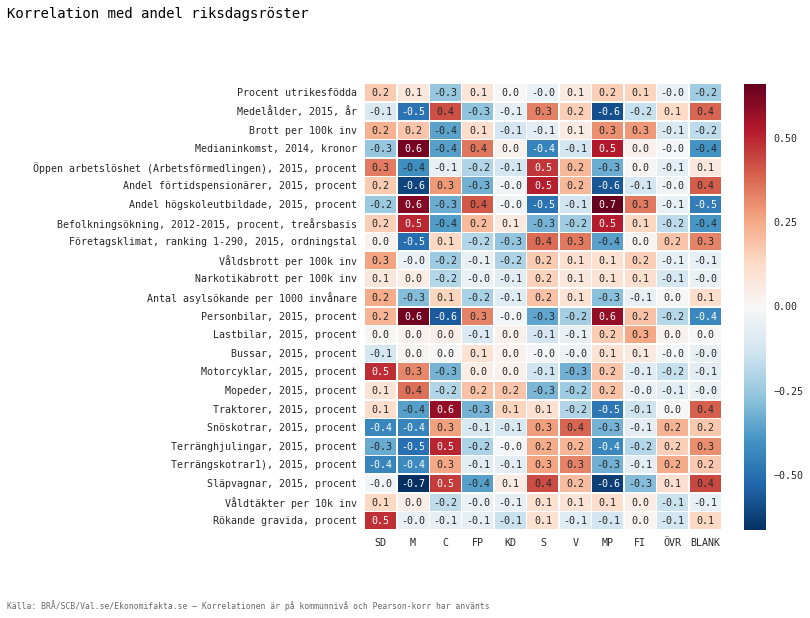

In [20]:
fig1 = plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    corr, 
    annot=True, fmt='.1f', linewidths=.5
)

ax.text(-1., 1.141, 
        u'Korrelation med andel riksdagsröster',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='#000000', fontsize=14)

ax.text(-1., -0.181, 
        u'Källa: BRÅ/SCB/Val.se/Ekonomifakta.se – Korrelationen är på kommunnivå och Pearson-korr har använts',
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='#666666', fontsize=8)

plt.savefig('SD_korr.pdf', bbox_inches='tight')

First of, a Persons `r` correlation ranges from 0 to 1. Zero meaning no correlation and one full correlation. Depending on textbook, somewhere over 0.4 will be a correlations to take seriously. But let's get back to that in a moment.

Some interesting correlations are though:

  - The right-wing populist party the Sweden Democrats (SD in the figure) 
    - Correlations with municipailtys having large porportions **motorcycles**,
    - and women **smoking while pregnant**.
    - Also high unemployment rate shows some correlation.
  - Right wing Moderaterna (M)
    - High percentage mopeds
    - High percentage cars
    - High education
    - High income
  - The Greens Miljöpartiet (MP)
    - Pretty much the same as Moderaterna. Only not that high income.
  - Centerpartiet (C) historically a party for the farmers
    - High correlation with tractors

So let's go into detail what a correlation of 0.5 actually is. Is it a fully linear correlation between smoking while pregnant and votage on xenophobic parties? Let's plot the municipalitys with these KPI:s on the axis.

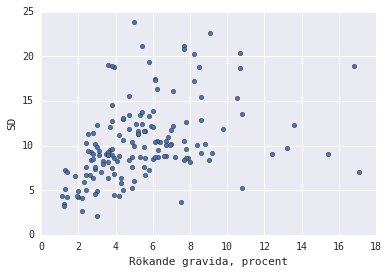

In [21]:
def corrplot_SD(kpi):
    (concat.replace(0, np.nan).dropna()
           .plot(kind='scatter', 
                 x=kpi, 
                 y=u'SD'))

corrplot_SD(u'Rökande gravida, procent')

If you ask me, that looks like a correlation. But that's also what I want to see since the Sweden Democrats is pretty much as far away from my personal political opinions you can go. I'd pretty much take any chance to misscredit them. So let's go further down the rabbit hole, but first plot the other KPIs.

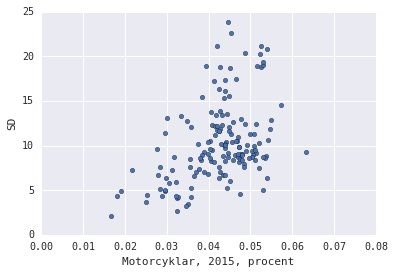

In [22]:
corrplot_SD(u'Motorcyklar, 2015, procent')

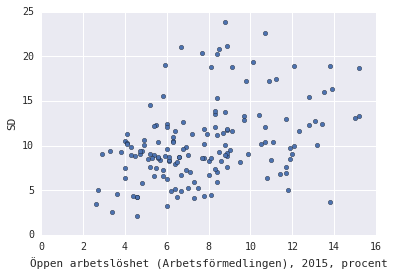

In [23]:
corrplot_SD(u'Öppen arbetslöshet (Arbetsförmedlingen), 2015, procent')

We are now going to calculate the `r` coefficient in a Bayesian fashion with Monte Carlo Markov Chains (MCMC). That will give us a distribution over `r` instead of a single number which allows us to give a upper and lower bound of the correlation. This closely follows the method described by [Philipp Singer here](http://www.philippsinger.info/?p=581).

You should read his blog post if you want more details. And in more general, Monte Carlo simulations is a really appealing way to solve problems. Whenever I get the chance, I recommend [Bayesian methods for hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers). The topics covered there should really be in any data scientist tool belt.

In [24]:
import pymc as pymc
from pymc import Normal, Uniform, MvNormal, Exponential
from numpy.linalg import inv, det
from numpy import log, pi, dot
import numpy as np
from scipy.special import gammaln

def _model(data):
    mu = Normal('mu', 0, 0.000001, size=2)
    sigma = Uniform('sigma', 0, 1000, size=2)
    rho = Uniform('r', -1, 1)
    
    @pymc.deterministic
    def precision(sigma=sigma, rho=rho):
        ss1 = float(sigma[0] * sigma[0])
        ss2 = float(sigma[1] * sigma[1])
        rss = float(rho * sigma[0] * sigma[1])
        return inv(np.mat([[ss1, rss], 
                           [rss, ss2]]))
    
    mult_n = MvNormal('mult_n', mu=mu, tau=precision, value=data.T, observed=True)
    
    return locals()
    
def analyze(kpi):
    freq_corr = corr.loc[kpi, 'SD']
    print "Standard Persons r correlations gave {}".format(freq_corr)
    data = np.array([concat['SD'].values, concat[kpi].values])
    model = pymc.MCMC(_model(data)) 
    model.sample(10000, 5000) 
    
    print "\nMCMC gives an lower and upper bound for this of {} and {}".format(
        *model.stats()['r']['95% HPD interval']
    )

In [25]:
analyze(u'Rökande gravida, procent')

Standard Persons r correlations gave 0.483367702644
 [-----------------100%-----------------] 10000 of 10000 complete in 24.5 sec
MCMC gives an lower and upper bound for this of 0.380729613024 and 0.795371509464


This tells us that the correlation is statistically sound. No `p`-values, just a interval that the true `r` should be in with 95 % probability. Even if it's *just* the lower bound 0.38 it's a correlation worth mentioning. But of course, it does not tell us if **correlation imply causation**. 